In [33]:
import numpy as np
import pandas as pd
from math import exp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model

df = pd.read_csv('data/fullDataset.csv')
print(df.shape)

dataset = df.values
#DEFINE TARGET VALUES
X = dataset[:,0:22]
Y = dataset[:,22]
print(Y)

target = []
for y in Y:
    target.append( exp(y))

df['transTarget'] = target
df.to_csv('transformedTarget.csv')
drop_percentage = 0.7
df_dropped_cols = df.copy(deep=True)

for col in df_dropped_cols.columns.values:
    no_rows = df_dropped_cols[col].isnull().sum()
    percentage = float(no_rows) / df_dropped_cols.shape[0]
    if percentage > drop_percentage:
        del df_dropped_cols[col]
        print("Column {} contains {} missing values. This is {} percent. Dropping this column.".format(col, no_rows, percentage))


(77414, 23)
[0.0255949  0.05561909 0.00538285 ... 0.01320861 0.03712879 0.00720394]
Column architectural_style contains 77208 missing values. This is 0.997338982612964 percent. Dropping this column.
Column building_class contains 77399 missing values. This is 0.9998062365980314 percent. Dropping this column.
Column pools contains 61277 missing values. This is 0.7915493321621412 percent. Dropping this column.
Column total_area contains 74405 missing values. This is 0.9611310615650915 percent. Dropping this column.
Column basement_area contains 77364 missing values. This is 0.9993541219934379 percent. Dropping this column.
Column number_of_levels contains 59854 missing values. This is 0.7731676440953833 percent. Dropping this column.


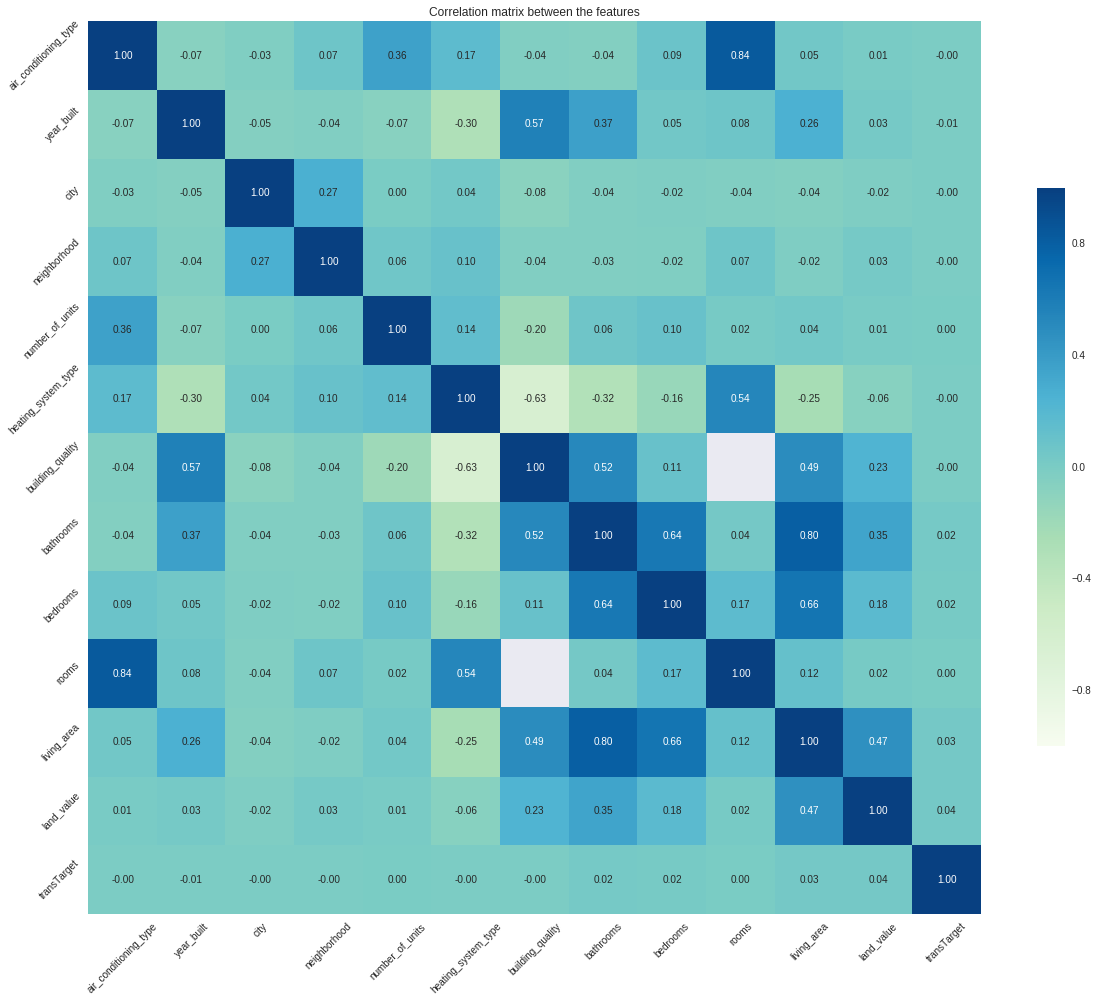

In [34]:
def corr_matrix(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(20, 20))
    ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True, fmt='.2f', cmap='GnBu',
                     cbar_kws={"shrink": .5}, robust=True)
    for item in ax.get_xticklabels():
        item.set_rotation(45)
    for item in ax.get_yticklabels():
        item.set_rotation(45)
    plt.title('Correlation matrix between the features', fontsize=12)
    plt.show()

# DISPLAY CORRELATED COLUMNS TO TARGET
def display_corr_with_col(df, col):
    correlation_matrix = df.corr()
    correlation_type = correlation_matrix[col].copy()
    abs_correlation_type = correlation_type.apply(lambda x: abs(x))
    desc_corr_values = abs_correlation_type.sort_values(ascending=False)
    y_values = list(desc_corr_values.values)[1:]
    x_values = range(0, len(y_values))
    xlabels = list(desc_corr_values.keys())[1:]
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.bar(x_values, y_values)
    ax.set_title('The correlation of all features with {}'.format(col), fontsize=20)
    ax.set_ylabel('Pearson correlatie coefficient [abs waarde]', fontsize=16)
    plt.xticks(x_values, xlabels, rotation='vertical')
    plt.show()
    plt.savefig('target.png')

#DROPPING COLUMNS BASED ON CORRELATION ANALYSIS
corr_cols_to_drop = ['garages', 'property_tax', 'structure_value', 'county', 'target']
for col in corr_cols_to_drop:
    del df_dropped_cols[col]

corr_matrix(df_dropped_cols)

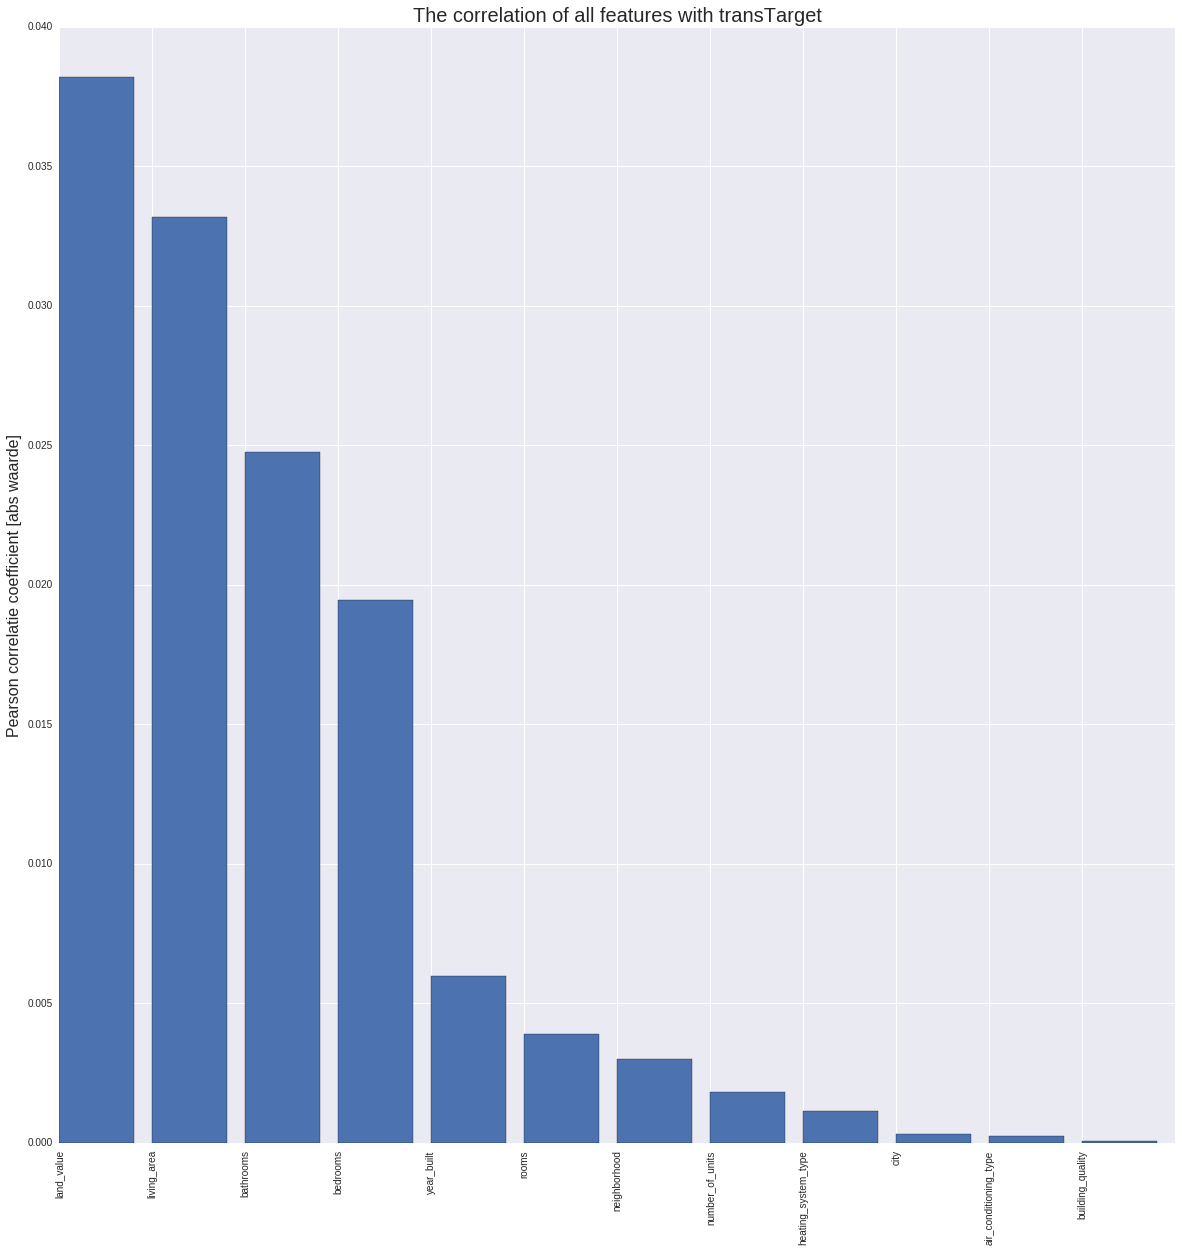

In [35]:
display_corr_with_col(df_dropped_cols, 'transTarget')

In [36]:
#ENCODING
def preprocess(csv_df, cols):
    le = preprocessing.LabelEncoder()
    for col in cols:
        csv_df[col] = le.fit_transform(csv_df[col].factorize()[0])
    x_cols_s = list(csv_df.columns.values)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df = scaler.fit_transform(csv_df)
    data=pd.DataFrame(scaled_df)
    data.drop([0, 1], axis=1)
    data.columns = x_cols_s
    del data['transTarget']
    data['transTarget'] = target
    print(data.head())
    return data

cols = ['air_conditioning_type','heating_system_type']
df_preprocessed = preprocess(df_dropped_cols, df_dropped_cols)

print(df_preprocessed.shape)

# PREPARE TRAINING AND TESTING DATA
def getValidationSet(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    data = df[mask]
    validation = df[~mask]
    dataset = data.values
    validation_set = validation.values
    X = dataset[:, 0:12]
    Y = dataset[:, 12]
    predict = validation_set[:, 0:12]
    actual = validation_set[:, 12]
    return dataset, validation_set, X, Y, predict, actual
dataset, validation_set, X, Y, predict, actual = getValidationSet(df_preprocessed, 0.9)



   air_conditioning_type  year_built      city  neighborhood  number_of_units  \
0                    0.0    0.007353  0.005714      0.000000            0.000   
1                    0.0    0.014706  0.011429      0.000000            0.000   
2                    0.0    0.022059  0.017143      0.000000            0.000   
3                    0.0    0.029412  0.022857      0.000000            0.125   
4                    0.2    0.036765  0.028571      0.002083            0.125   

   heating_system_type  building_quality  bathrooms  bedrooms   rooms  \
0                  0.0          0.000000   0.045455    0.0625  0.0625   
1                  0.0          0.000000   0.090909    0.1250  0.1250   
2                  0.0          0.000000   0.136364    0.1875  0.1875   
3                  0.1          0.083333   0.181818    0.0625  0.0625   
4                  0.1          0.083333   0.181818    0.1875  0.0625   

   living_area  land_value  transTarget  
0     0.000205    0.000019     1

In [43]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(predict)
for a, b in zip(predictions, actual):
    print(a, b)

1.0385503315580966 1.0069644993076037
1.0425516558607262 0.963904224968235
1.038436599567727 0.9829796731807414
1.0269268614322993 1.0429375110290804
1.0413902294514725 0.9749275505240732
1.0494217926478595 1.0043377214961517
1.060062057583241 0.7714775866913155
1.0621652706345608 1.0467789348548435
1.0213491393027878 1.1084557674379483
1.0544764621992526 1.0156044199532368
1.0618844091209825 1.0176785495365155
1.0195763017849706 0.995390000518324
1.0439102535653797 1.0396070305420808
1.064588919511271 0.9749753180745968
1.025017769073872 1.0350445333676113
1.0527041397264056 0.9920028045836508
1.030135810841774 1.162340820846788
1.0486413253924478 0.9823668904254823
1.0609885494999725 0.9987045732905162
1.0317494572790227 1.0610326347060974
1.0285437032433509 1.0155626833284876
1.10283441019606 0.9892893368408803
1.0166191765909764 1.0222959124634479
1.0941810292733887 0.9775705710314376
1.0551056743971805 0.9580381684491327
1.038302801867237 1.0219086099157155
1.0144732161670131 1.00

1.0633589391255465 0.9823028401293857
1.026693467184152 1.0289667397055287
1.0662989193521872 1.04246246046897
1.0251164216258986 1.9172324239541745
1.0234891695513675 1.0181969465387528
1.034715565835136 0.9227464973141128
1.026220357704638 0.9848995027304981
1.0536792224531157 0.9871362237386202
1.0502205453515483 1.3229526694198315
1.0300855301490652 1.045027821596819
1.0298371518553011 1.0120274955378563
1.0192171315470786 0.9083269965068236
1.0474774088570518 1.015283333352694
1.0317273263706903 0.946217981930797
1.0700009554660788 0.9386960659533322
1.009844393947033 1.0095212991899627
1.017190255827865 1.042621797186411
1.0434218491786666 0.6149199236501468
1.057670815885038 1.0223243768492658
1.0208498065917229 1.0618148101242644
1.0429057586171213 0.9923660344651405
1.0663869781950865 1.1491145728850105
1.026936715147783 1.0040181820328171
1.0319313503793914 0.9894335963286204
1.031784555298909 0.9649225151966336
1.0217134537288568 1.2424695554095997
1.029175878737024 1.113789

1.0303367415892235 1.0085337013936606
1.024945042845928 0.8614677570827771
1.0222885412332172 1.1858452422266468
1.0727680269867759 1.0385622228292088
1.0186289339545007 1.0788666790385288
1.017447953898127 1.0086734000454367
1.0448658905566062 1.0270692554648322
1.0339342724046556 0.9865755981147484
1.0776363818391892 0.9347478698239405
1.0184889041478726 0.9796899621740934
1.035920253362925 1.0061031376123877
1.0363229843830664 0.9817623293101979
1.058502103170009 1.0106719659980161
1.0421597037484167 0.975393840472021
1.0259050954782905 1.0855158263404157
1.0325143725068868 1.0334213125746927
1.0277434353779553 1.1616656658397126
1.028219550016129 1.0156345834461873
1.0283973005266553 1.0361042402732397
1.0358537234067844 1.0132481880813409
1.0448629735289026 0.9910712980302444
1.0432726776268348 1.0247233101166116
1.0324589454580033 0.9579447511573929
1.0261746380562589 0.9332940992391437
1.0107238624062422 1.0291552046070012
1.0358240439595563 0.9187132589621506
1.0077266632255932

1.0604115171629918 0.9921002618412972
1.1040952897602727 0.9978096072190694
1.0299686143880977 0.9868727034184547
1.0501728619385013 1.0173189708711452
1.067513972966274 1.0127912209784946
1.0216111365177933 1.0249225258529404
1.0211646391980822 1.1717355616440508
1.0308307759830289 1.037216408029746
1.0262478351058952 0.9801492631290974
1.0431565941005958 1.0308419820443795
1.0384869606230596 0.9940375153867417
1.0455753894411757 1.0304096314329156
1.031990299005891 0.9164706216073009
1.018010047906012 0.9683329453844454
1.0594514959359547 1.015587495249723
1.064716377361135 0.9989084103179401
1.0417181068886698 1.0311902156672814
1.0679365888835868 0.872187103723004
1.0225526462635384 1.0152249587774467
1.0256682140810616 1.0233977917212689
1.0424107686996888 1.0641420786813256
1.0326747330213368 0.9566228712745501
1.1041724487406337 0.98449564576594
1.0517214381133047 1.000638910316302
1.029495367539023 0.9390498096125061
1.0199198195586185 0.9449995717151297
1.0569323409476055 0.99

1.0395217492784072 1.0073266824546467
1.0250801311585196 0.9678981639216659
1.0189295508641079 1.280314598486332
1.0222232793082395 1.0004731199859715
1.023753767942616 0.9432236859914268
1.0234421907458813 1.3197002216559772
1.0329263584921624 1.0025221215107332
1.0238083517123215 0.9142482127825539
1.041801956193732 0.9977608481490223
1.014808749422249 1.3150421701885626
1.0361844928210342 1.0405645154435939
1.0154169557743418 0.9688852966579579
1.047478566708487 1.0211521141084048
1.1218195267165219 0.9078752278365299
1.0392563888026538 1.1380804766245123
1.0644335682764297 1.0333181677041992
1.0027698129362235 1.0275753602420197
1.025912174900545 0.9801036041352202
1.055763473677567 0.9955016518125059
1.0299096241157724 1.025404470171867
1.0337109671391707 0.8642997469533467
1.0188416597014442 0.9468039257650361
1.0275265541096366 1.0157311429939648
1.0384811206236655 0.9837900903514485
1.0276949346922084 1.0400977155508426
1.033670578616635 0.9658285756851497
1.0576583625277765 0.

1.0461941368318135 1.0191006983359554
1.027430029764708 0.9931175962719399
1.0456650884271943 1.0167286798858237
1.0085347127038284 1.0868070139363366
1.0039547691247348 0.9596840799168828
1.0161593754862297 1.0055855653250942
1.0294831251278194 1.0257892875516204
1.018911204892763 0.9623388368249598
1.0307305129005657 0.9516914114257577
1.0255222914515283 1.0987119991608265
1.0482388230975066 0.7460533317889314
1.0410388405041988 1.032638496909455
1.041411326694912 1.02130225840123
1.0274734032896402 1.1858543387618046
1.0746281712898553 0.9973615731824663
1.0361366539382655 0.9531880952331182
1.0180373775176748 0.939966112029865
1.0234076005967836 1.0033252631618055
1.0143745102105042 1.054757051109261
1.0467013068084676 1.0109016875191448
1.0284663649513075 1.0801283833030584
1.0369502894604994 0.9975746737677572
1.0239806079108191 1.2258922250986142
1.0500219034462948 0.8131527617122799
1.0480478891947653 1.0312021502163045
1.1176255014178527 1.0358119312338285
1.0385581904310617 1

1.0233674811439233 1.0068478582890759
1.048084444995748 0.8677885457385762
1.0320438207968277 1.0191363435348992
1.0224656957359801 1.082264977101693
1.0421269451813198 0.9873459515561813
1.010227613271662 0.9277771203300498
1.1019006029034233 1.0486423746182787
1.0243155662948553 0.9686576146352197
1.1053181192635382 0.9666558677801443
1.0357264503781913 0.9836510641720293
1.0775117363740914 1.025619759416076
1.0407675258920992 2.0679229974969338
1.0849238161112438 1.02187201755642
1.040779199793085 0.9816725185606514
1.032488897010923 1.032220506061792
1.083009471272144 0.9395267555828084
1.0323404958768925 1.0925424627084757
1.0386161599613377 1.3641450814986178
1.038751260653975 1.0145950993411863
1.0329208287048253 0.8867297610741561
1.0733975065784795 0.9553903486230527
1.016529169535138 1.049401129395872
1.0352183480554975 1.0217478749029565
1.0406199499575322 0.7251667148101293
1.026850325166521 1.010373680479532
1.0370524229292208 0.9521592453997832
1.041535770867073 1.0593775

1.034550363223316 0.9077390584901442
1.0436273833448886 0.9667280699065945
1.0324513224093048 1.0151182532778982
1.052476273007923 1.0281539054502133
1.0251837589125397 1.1152488507062062
1.0418530749710024 1.095813683754054
1.0245066701251908 0.9992718952969646
1.0240339372522014 1.024148840904015
1.0395156982882594 1.0124717793872535
1.0394245509302193 1.0187278005863225
1.0422998883763297 1.0266525351927533
1.0578226393061565 1.0945531647890703
1.0355306266193216 1.0377158375718343
1.032087298872673 0.993972948087128
1.0254214345764596 0.8387707317206888
1.0383848018574897 0.9497878398521893
1.043831133661988 1.0405059489180661
1.0181670722125977 0.9776627547102631
1.0179447232712948 1.0998541802412796
1.0065349565461192 0.9953994822504726
1.0624618938071553 0.9856479011297036
1.0315336686667318 0.9637687493648094
1.0265761721441782 0.9964270581017193
1.0347230970078782 0.9688809038388696
1.0947035906471176 10.168103295333708
1.0472780967230968 1.134065373235752
1.0305572922689215 0

In [40]:
model = sm.OLS(Y, X).fit()
# make the predictions by the model
predictions = model.predict(predict)

for a, b in zip(predictions, actual):
    print(a, b)
# Print out the statistics
model.summary()

0.6592392773731723 1.0069644993076037
0.5965711207235228 0.963904224968235
0.692025828525638 0.9829796731807414
0.7224917601052274 1.0429375110290804
0.5746692316185755 0.9749275505240732
0.6589438466087167 1.0043377214961517
0.9970527277362098 0.7714775866913155
0.6426977796614466 1.0467789348548435
0.7003501545880513 1.1084557674379483
0.5583646060827675 1.0156044199532368
0.6771157533895378 1.0176785495365155
0.7996526155163068 0.995390000518324
0.8080296942595386 1.0396070305420808
0.6951315890982062 0.9749753180745968
0.7103312140211868 1.0350445333676113
0.5964923978520524 0.9920028045836508
0.8396094342850713 1.162340820846788
0.7694471647958605 0.9823668904254823
0.4932336140539344 0.9987045732905162
0.737642958995212 1.0610326347060974
0.5190083807263344 1.0155626833284876
0.9604379131203641 0.9892893368408803
0.4202746291033927 1.0222959124634479
0.746605710586824 0.9775705710314376
0.6100533030445506 0.9580381684491327
0.5107936463700213 1.0219086099157155
0.7897543414104793

1.1814505953674592 1.0261688605096837
0.9697398092980606 1.0821206867083397
1.0466119076739941 1.0574835295252665
1.055576134325939 0.9454408895505179
1.1039356760449295 1.2245862121081814
0.9223913374745759 0.9872454545291963
1.6056078806038745 0.9675250486846597
1.0957960669404998 0.986847519636584
0.9009107209663608 0.9087781572683552
0.7058362919252139 0.9444592174088227
0.8342621741370626 1.0334919496454384
0.810393393889557 0.8754273859389052
0.7059236689862294 0.9353701331458015
0.9198545607215735 0.9206448014437623
0.8655460031569302 0.9942729839395738
0.8343232063878203 0.9936910820245345
1.3513590375842215 29.801063035281523
0.5625110290526698 1.0057729400636048
0.779805241815412 0.9777199841678643
1.1101433142408172 0.9955196851896122
0.641598361239441 1.145020370411098
0.9759181725211592 0.978383451980519
1.6431433289358501 1.015525199296955
1.2660599712847844 1.0074905141916644
0.5571715344434462 1.0084697182129057
0.9534257101649786 0.9877866626915713
0.9559837807469795 1

0.8420199188903327 1.1265516760043144
0.8864017938064428 0.9858026298328733
1.055365533095379 1.0354824384277184
1.0267284080678785 1.017060489433481
1.4954723397967176 0.9952055785069502
0.848267212603135 1.0980552628661584
1.1060897977641608 1.0417022190230927
1.2907174646515176 1.0058896310771537
0.9216865148191989 0.9789826958889719
1.0127983289958165 0.9138182770535989
0.8395529554466068 1.0172971610069819
0.9873808533492958 0.9628591380254383
1.116002228154501 1.0160981401224074
0.7705807013041917 0.9818542116407617
0.9078864724337781 0.9789176580613532
1.321249443772232 1.1868735045569416
1.0292407662582237 1.0285451871004327
1.3062766255813885 1.0364337042699987
1.1128307124758594 0.8159008449035469
1.2768573684054896 1.0632756968816492
0.7970069753606062 1.010121560053984
0.8855260208685016 0.9708607976029484
0.8237181729131785 0.912543154537424
0.9138564634242454 0.999336366702049
0.9535454452583363 1.000818697149709
1.227700626321358 0.9760087695643854
1.0606720019429168 1.0

1.06445902200072 1.0518999777385445
0.8098052633539932 0.9677998817570281
1.7318798965507693 1.192542849703255
0.9626020686761322 1.0059164839610435
0.8492145386313297 0.9533820846491259
0.981901692826725 0.9403317444988138
0.8977807728424727 1.069930208344227
1.1669370296586037 1.1348417489789837
2.4121887095764984 0.8318683169367231
0.938761499747367 1.0092998362282937
1.9757797886755888 0.9570583125800268
0.827253613357483 0.9509773233299139
1.181095592044675 0.9619352772939537
1.887592451705145 0.9716585763759746
1.0406483243645366 0.9557265825057553
0.9832896089191329 0.9812459928633473
0.7838401477700375 1.005511945179115
1.0380771320873934 1.0625076370474846
1.0041555651912901 0.9395655674830988
0.8384866891729466 0.9136947519758801
1.4795678537785704 1.0299681740669135
0.7790184202320392 0.9840641015500258
0.9009589332297249 1.0103804230287114
0.8918060120124683 1.0059818843388992
1.2558806987050304 0.9841160699697166
1.0818441039054083 1.1795044064249143
0.79851565903921 1.035

0.9610691172986731 0.9570823123623021
1.1578063497038793 1.036025453758051
0.9559244581988658 0.9975531904304291
1.0600227880929318 0.9952515172614839
0.9631522836595665 0.9953030247512737
1.3001503920124247 0.9520568116198944
1.2895388794614902 0.9969673948647964
1.0351466999811996 1.023941011396584
0.8721176010696565 0.9975775162610824
0.7061112539504893 0.9033910207560039
0.9294138451054205 1.0053142553262082
0.9640697110789486 0.9329964610768737
0.9678429462774698 1.014289441800722
0.9231255462178547 0.9559563663171764
1.0131772560713947 1.002294432791546
1.072918631814518 1.005472984960379
0.9872927302369887 1.0023437364663812
1.109013608882607 1.0296810940778134
0.9733365122342259 0.9999886801745554
1.028592393866114 1.099577976102396
1.1906112996478875 1.5814431319215843
1.0030610999526308 1.0271651828720232
1.0256490444538362 0.9936127467803468
0.6922360833615419 0.9397300043417774
0.8858449359606807 1.0104074212595067
0.9450143113505944 0.9502665965583998
0.9493819905715843 0.

0.7093399790179842 0.998054431177423
1.1400250947381458 1.036456761134289
0.9904719243846491 1.0347054280206716
1.4275986936982297 0.8599890613293091
0.944577485835252 1.0119156786482286
1.0558930016469343 1.0004423644142921
1.2778464903408326 0.9842269563771542
0.7780443717750243 0.9581889463002887
1.2530824016778872 0.9211759944263075
1.0913487423410644 1.0246519958522744
1.0000004217441363 0.9340724043878534
0.9795271449150115 0.9751119278287237
0.7832378317131115 0.9487965421413969
0.9390044049669385 1.0204199816832162
0.8901206103018388 0.9426365060896832
1.0380482615774227 1.0553005022227637
1.5389807583674175 0.9733885105241493
0.8777256440123943 0.847775422009949
1.0303948201212725 0.9774617493382723
1.8241351477041545 1.0582301794605955
0.915807781613027 1.0069848602349305
1.0522639768604436 0.9809476209198578
1.192356165310677 1.0175358222933497
0.7909119636964731 0.9812692911579178
0.9666562687467826 0.9260031571430788
1.011836835103197 1.0356135220259628
1.0294285766160602 

1.0967703571500076 1.0223993761918957
1.1019712995625826 1.223142316064401
0.9139793859379666 1.0197437418995903
1.0607757228243468 0.9994065105845557
1.0639850773273318 1.0496184595744158
0.7710477293702971 1.0080111171429342
1.1911848775880003 1.0611746977052552
1.478329587610072 0.7808918735388926
1.8436028515760898 1.042556762969355
0.7250918750008957 1.0196033643594589
0.9207238453461517 1.0510538837393864
0.7760817518966665 1.0089322817528152
1.373029371323466 1.0592201387604059
0.77470718360936 1.0082423857536473
1.118264273616231 0.6992661272684716
0.6978865621460266 0.9396444058851048
0.9016402341649978 0.9096305191799725
0.8617020234391958 1.0928791411091208
1.0372406952143294 1.060132994327044
0.9797508666873156 0.9649868174596827
0.9811218066083187 1.0005301275679774
0.8033313908513946 1.0187478952922462
1.20364567063208 1.0583134588914362
0.9428398285153529 0.6700853687962921
0.8691448072966292 0.991286535306454
1.0083433542280353 0.9469247837204843
1.047419371675843 1.033

0.8309651934500959 1.0459016393678653
1.7036087266804163 1.1451903138914672
1.0243227700306916 1.0529341779197392
0.8699005566080455 1.01869518419486
1.0640755423889507 1.024564962226909
1.0269758469358408 0.9940269308322268
1.2603594152169955 2.1372474470046656
0.8883207227062574 1.1294301198545413
0.7377299065152012 1.034301448639918
1.337094802299436 1.0167409886810743
0.9958192323886935 0.9685217237326124
0.6954853690750238 1.0617301065893803
1.6163729335938102 1.0301120820030074
1.1165304835902372 0.9821938819708768
1.6322535745429385 0.8811050036132163
0.9717391744888467 1.1128370652844013
0.9271785419961722 0.9655112621535334
0.8477072331376231 0.9948453652602032
0.7891906435478881 1.0022227761121996
0.9365369814556017 1.1175612988966779
1.2003317803566889 1.0446552343509004
0.9627578431728885 1.0059600672427655
0.6040246144255723 0.988339249433746
1.5401405422347956 1.0310399853938568
1.1821091769076233 0.9820171450130412
0.853256533796457 1.0435909867992188
1.0525025190578565 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     7718.
Date:                Mon, 07 May 2018   Prob (F-statistic):               0.00
Time:                        00:01:51   Log-Likelihood:                -90288.
No. Observations:               69784   AIC:                         1.806e+05
Df Residuals:                   69772   BIC:                         1.807e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1456      0.031      4.660      0.000       0.084       0.207
x2             0.3865      0.014     26.810      0.000       0.358       0.415
x3             0.2682      0.014     19.208      0.000       0.241       0.296
x4             0.1980      0.022      8.898      0.000       0.154       0.242
x5             0.9688      0.055     17.522      0.000       0.860       1.077
x6             0.8054      0.043     18.760      0.000       0.721       0.890
x7             0.1496      0.022      6.911      0.000       0.107       0.192
x8             1.0537      0.035     30.483      0.000       0.986       1.121
x9             0.7420      0.032     23.034      0.000       0.679       0.805
x10            1.0046      0.032     31.430      0.000       0.942       1.067
x11            0.1961      0.017     11.806      0.000       0.164       0.229
x12            0.2543      0.011     23.594      0.000       0.233       0.275
==============================================================================
Omnibus:                   314180.349   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    2981507289601.105
Skew:                         150.230   Prob(JB):                         0.00
Kurtosis:                   32023.382   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""